In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
root = '/home/ddmonster/lane_det_dataset'
print(os.listdir(root))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['val', 'train_label', 'val_label', 'train']


In [2]:
train = os.path.join(root, "train")
train_imgs = os.listdir(train)

train_labels = os.path.join(root, "train_label")

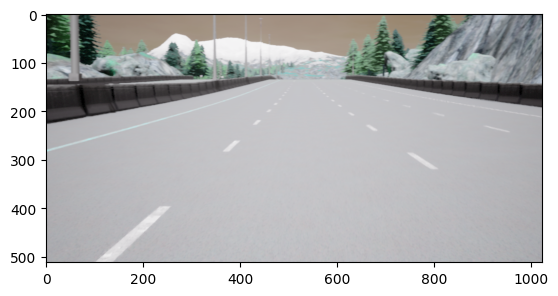

In [3]:
import matplotlib.pyplot as plt

img = plt.imread(os.path.join(root, "train", train_imgs[0]))
plt.imshow(img)
plt.show()

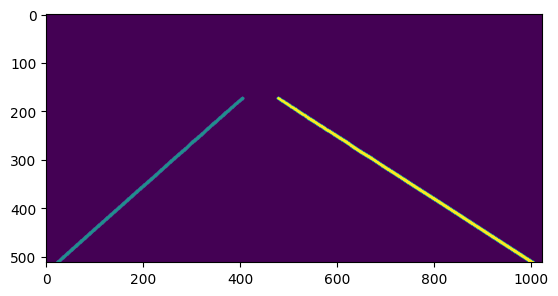

In [4]:
label_images = os.listdir(train_labels)
img = plt.imread(os.path.join(root, "train_label", label_images[0]))
plt.imshow(img)
plt.show()

In [5]:
print(label_images[0])
print(train_imgs[0])

Town04_Clear_Noon_09_09_2020_14_57_22_frame_2407_label.png
Town04_Clear_Noon_09_09_2020_14_57_22_frame_3193.png


In [6]:
!pip install segmentation-models-pytorch
!pip install albumentations 

In [7]:
DATA_DIR = root
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_label')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_label')

In [8]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [9]:
from torch.utils.data import DataLoader, Dataset
from torch import LongTensor

In [10]:
import re
import cv2

class CarlaLanesDataset(Dataset):
    """ Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['background', 'left_marker', 'right_marker']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        #random.shuffle(self.ids)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        get_label_name = lambda fn: re.sub(".png", "_label.png", fn)
        self.masks_fps = [os.path.join(masks_dir, get_label_name(image_id)) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, LongTensor(mask)
        
    def __len__(self):
        return len(self.ids)

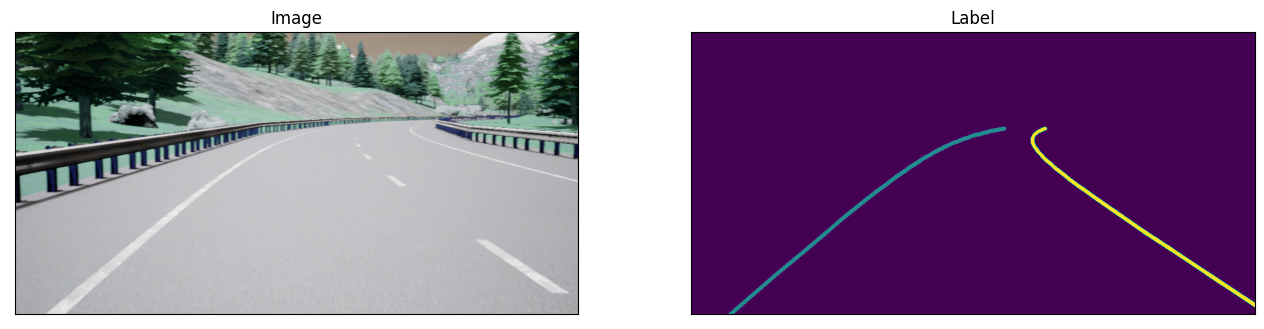

In [11]:
dataset = CarlaLanesDataset(x_train_dir, y_train_dir, classes=CarlaLanesDataset.CLASSES)

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    label = mask
)

In [12]:
import albumentations as albu


In [13]:
def get_training_augmentation():
    train_transform = [
        albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=0., shift_limit=0.1, p=1, border_mode=0),

        albu.IAAAdditiveGaussianNoise(p=0.2),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.6,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.6,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.6,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    return None

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):   
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor),
    ]
    return albu.Compose(_transform)


/home/ddmonster/miniconda3/envs/mlmas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/home/ddmonster/miniconda3/envs/mlmas/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1260: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/home/ddmonster/miniconda3/envs/mlmas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/home/ddmonster/miniconda3/envs/mlmas/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1286: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


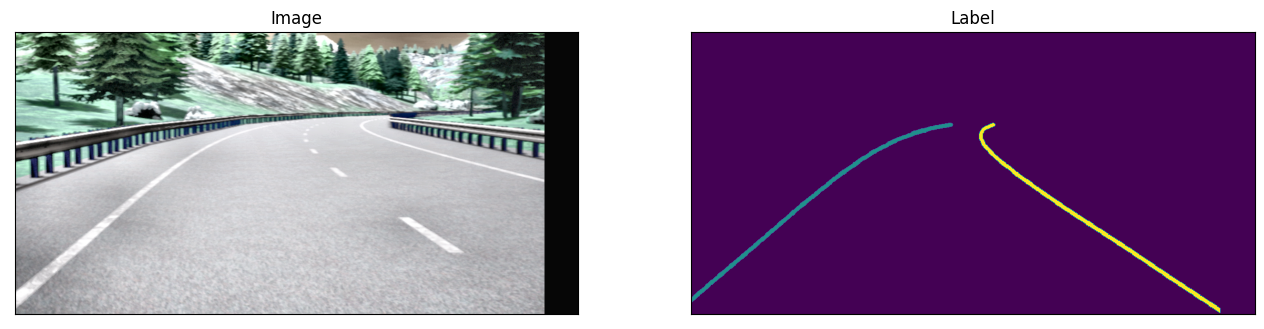

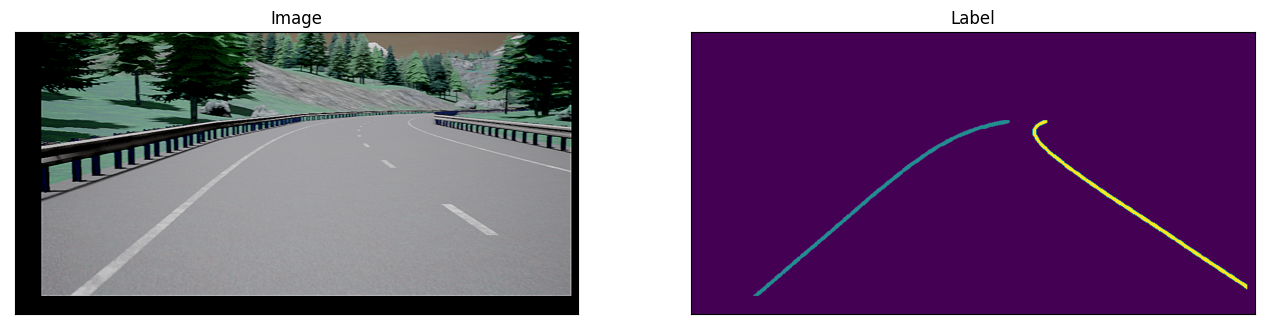

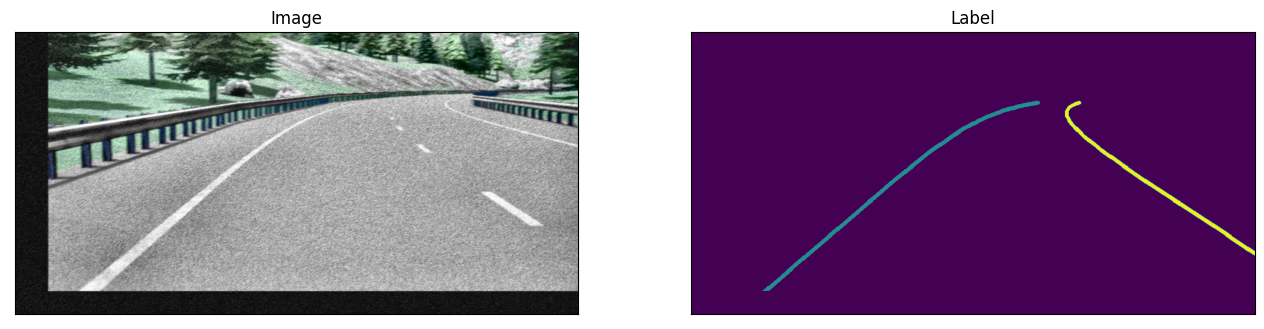

In [14]:
#### Visualize resulted augmented images and masks

augmented_dataset = CarlaLanesDataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=CarlaLanesDataset.CLASSES,
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, label=mask)

In [15]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [16]:
loss_string = 'multi_dice_loss'

ENCODER = 'efficientnet-b0'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d'
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CarlaLanesDataset.CLASSES), 
    activation=ACTIVATION,
    #encoder_depth = 4
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [17]:
train_dataset = CarlaLanesDataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CarlaLanesDataset.CLASSES,
)

valid_dataset = CarlaLanesDataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CarlaLanesDataset.CLASSES,
)

/home/ddmonster/miniconda3/envs/mlmas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/home/ddmonster/miniconda3/envs/mlmas/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1260: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/home/ddmonster/miniconda3/envs/mlmas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/home/ddmonster/miniconda3/envs/mlmas/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1286: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [18]:
bs_train = 8 
bs_valid = 8 
train_loader = DataLoader(train_dataset, batch_size=bs_train, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=bs_valid, shuffle=False)

In [19]:
from segmentation_models_pytorch.utils import base
from segmentation_models_pytorch.utils.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import Accuracy

label_left = CarlaLanesDataset.CLASSES.index('left_marker')
label_right = CarlaLanesDataset.CLASSES.index('right_marker')

class MultiDiceLoss(base.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.BinaryDiceLossLeft = DiceLoss()
        self.BinaryDiceLossRight = DiceLoss()
        
    def forward(self, y_pr, y_gt):
        #print("shape y_pr:", y_pr.shape)
        #print("shape y_gt:", y_gt.shape)
        # ypr.shape=bs,3,512,1024, ygt.shape=bs,512,1024
        left_gt = (y_gt == label_left)
        right_gt = (y_gt == label_right)
        loss_left = self.BinaryDiceLossLeft.forward(y_pr[:,label_left,:,:] , left_gt)
        loss_right = self.BinaryDiceLossRight.forward(y_pr[:,label_right,:,:] , right_gt)
        return (loss_left + loss_right)*0.5

In [20]:
import torch

metrics = []
loss = MultiDiceLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

In [21]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [22]:
best_loss = 1e10

for i in range(0, 5):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if best_loss > valid_logs[loss_string]:
        best_loss = valid_logs[loss_string]
        torch.save(model, './best_model_{}.pth'.format(loss_string))
        print('Model saved!')
        
    if i == 3:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 17/17 [00:03<00:00,  4.65it/s, multi_dice_loss - 0.239] 
Model saved!

Epoch: 1
valid: 100%|██████████| 17/17 [00:03<00:00,  4.63it/s, multi_dice_loss - 0.162] 
Model saved!

Epoch: 2
valid: 100%|██████████| 17/17 [00:03<00:00,  4.64it/s, multi_dice_loss - 0.1502]
Model saved!

Epoch: 3
valid: 100%|██████████| 17/17 [00:03<00:00,  4.70it/s, multi_dice_loss - 0.1338]
Model saved!
Decrease decoder learning rate to 1e-5!

Epoch: 4
valid: 100%|██████████| 17/17 [00:03<00:00,  4.62it/s, multi_dice_loss - 0.1171]
Model saved!


In [22]:
best_model = torch.load('./best_model_multi_dice_loss.pth')


In [23]:
test_best_model = True
if test_best_model:
    # create test dataset
    test_dataset = CarlaLanesDataset(
        x_valid_dir, 
        y_valid_dir, 
        augmentation=get_validation_augmentation(), 
        preprocessing=get_preprocessing(preprocessing_fn),
        classes=CarlaLanesDataset.CLASSES,
    )

    test_dataloader = DataLoader(test_dataset)

    # evaluate model on test set
    test_epoch = smp.utils.train.ValidEpoch(
        model=best_model,
        loss=loss,
        metrics=metrics,
        device=DEVICE,
    )

    logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 129/129 [00:08<00:00, 14.91it/s, multi_dice_loss - 0.1142]


In [24]:
# test dataset without transformations for image visualization
test_dataset_vis = CarlaLanesDataset(
    x_valid_dir, y_valid_dir, 
    classes=CarlaLanesDataset.CLASSES,
    preprocessing=get_preprocessing(preprocessing_fn)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 512, 1024)
torch.Size([1, 3, 512, 1024])
torch.Size([512, 1024])
(512, 1024)


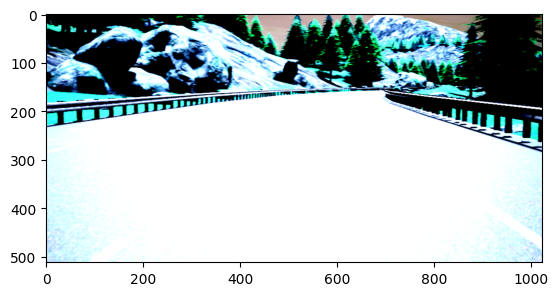

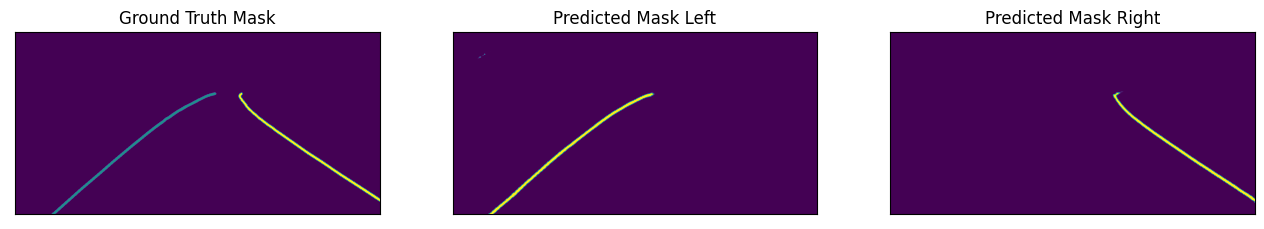

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 512, 1024)
torch.Size([1, 3, 512, 1024])
torch.Size([512, 1024])
(512, 1024)


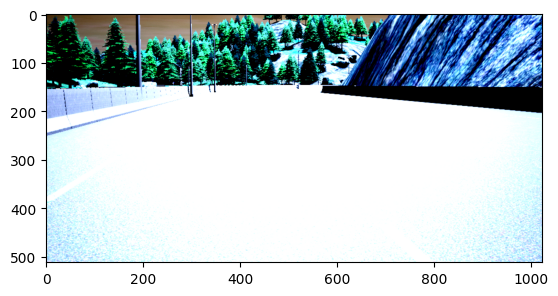

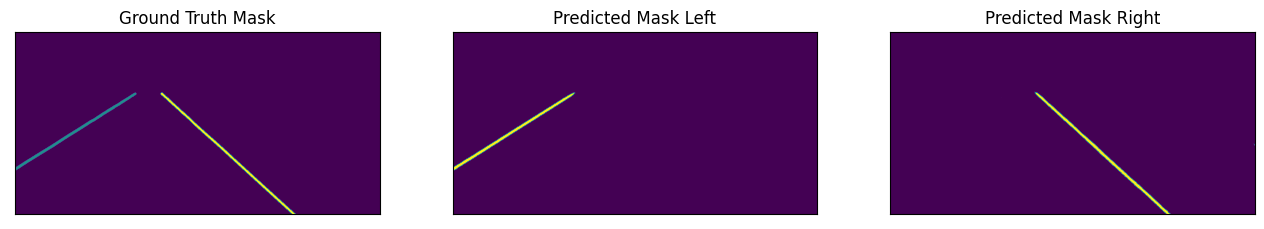

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 512, 1024)
torch.Size([1, 3, 512, 1024])
torch.Size([512, 1024])
(512, 1024)


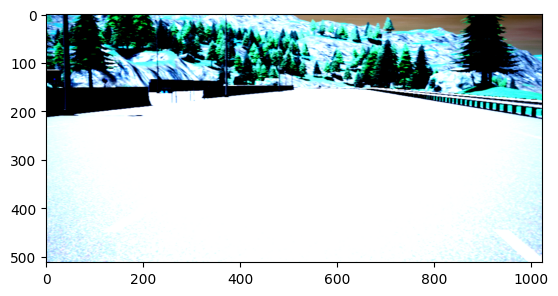

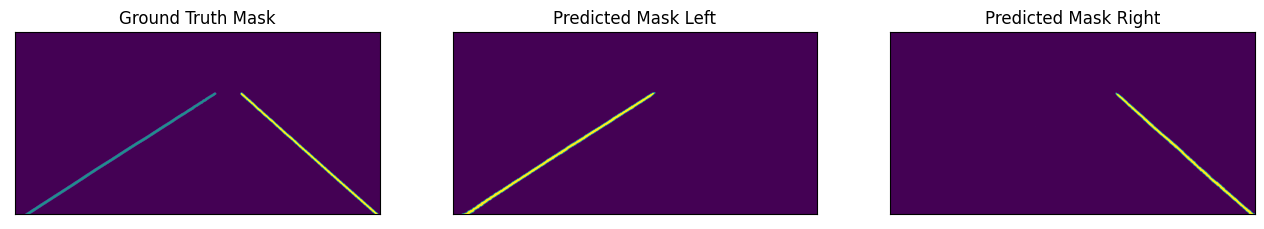

In [37]:
for i in range(3):
    n = np.random.choice(len(test_dataset_vis))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset_vis[n]
    print(np.shape(image))
    plt.imshow(image.transpose(1, 2, 0))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    print(np.shape(x_tensor))
    print(np.shape(gt_mask))
    pr_mask_left = best_model.predict(x_tensor)[0,1,:,:] 
    pr_mask_left = (pr_mask_left.cpu().numpy())
    print(np.shape(pr_mask_left))
    pr_mask_right = best_model.predict(x_tensor)[0,2,:,:] 
    pr_mask_right = (pr_mask_right.cpu().numpy())
        
    visualize( 
        ground_truth_mask=gt_mask, 
        predicted_mask_left=pr_mask_left,
        predicted_mask_right=pr_mask_right
    )

/home/ddmonster/MLMAS_Project/imgdata/saved_image_rgb_front_20240701_065427.png
(512, 1024, 4)
torch.Size([1, 3, 512, 1024])


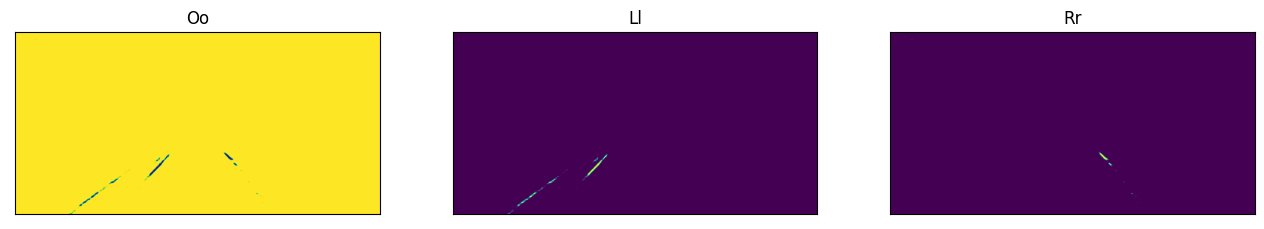

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 512, 1024)


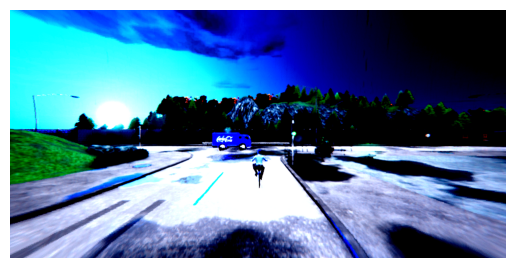

/home/ddmonster/MLMAS_Project/imgdata/saved_image_rgb_front_20240701_065309.png
(512, 1024, 4)
torch.Size([1, 3, 512, 1024])


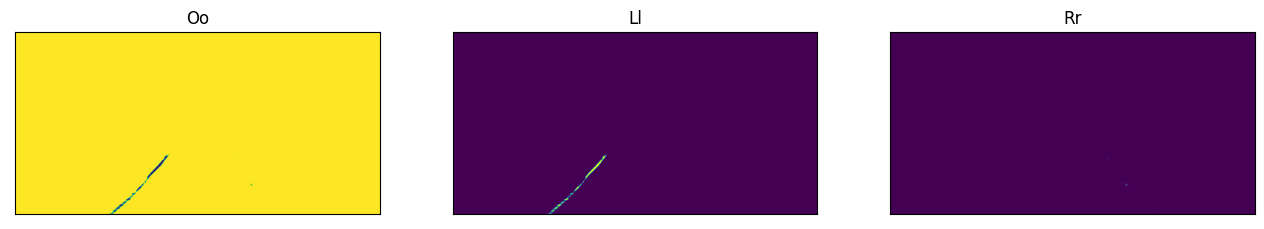

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 512, 1024)


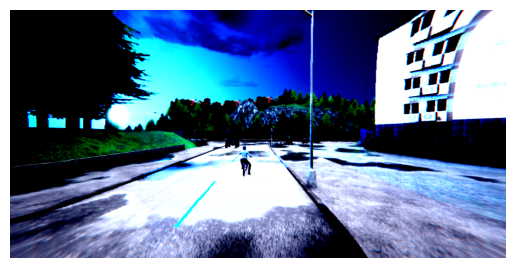

/home/ddmonster/MLMAS_Project/imgdata/saved_image_rgb_front_20240701_065514.png
(512, 1024, 4)
torch.Size([1, 3, 512, 1024])


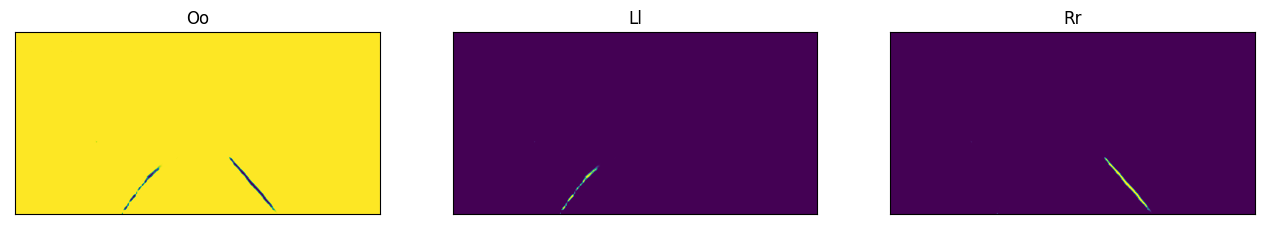

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 512, 1024)


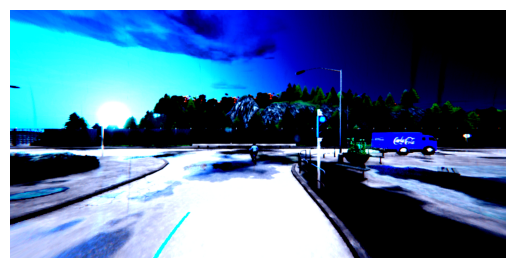

/home/ddmonster/MLMAS_Project/imgdata/saved_image_rgb_front_20240701_065348.png
(512, 1024, 4)
torch.Size([1, 3, 512, 1024])


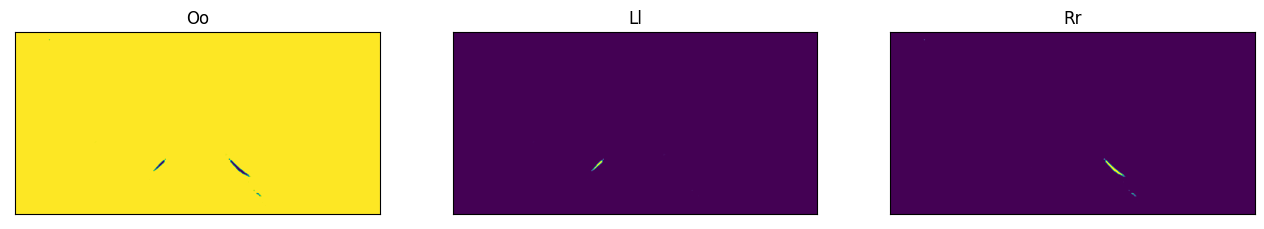

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 512, 1024)


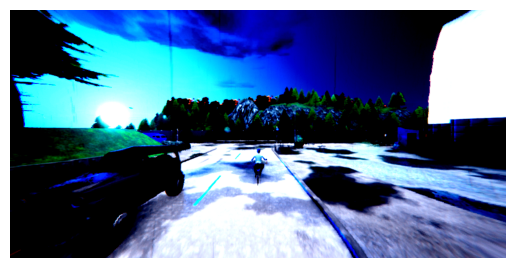

/home/ddmonster/MLMAS_Project/imgdata/saved_image_rgb_front_20240701_065507.png
(512, 1024, 4)
torch.Size([1, 3, 512, 1024])


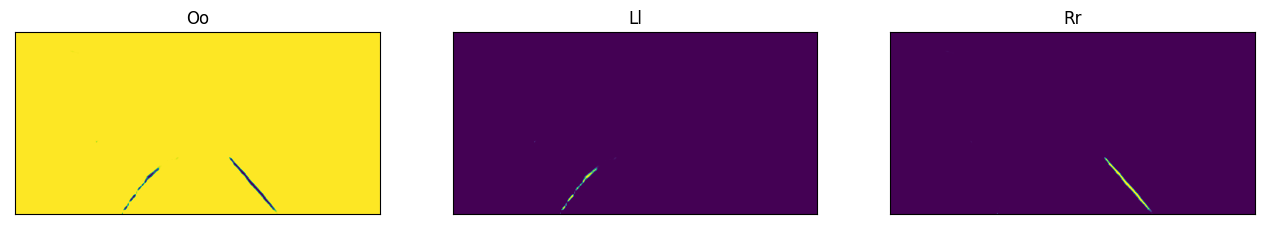

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 512, 1024)


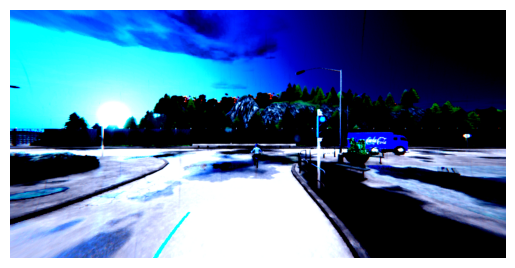

/home/ddmonster/MLMAS_Project/imgdata/saved_image_rgb_front_20240701_065355.png
(512, 1024, 4)
torch.Size([1, 3, 512, 1024])


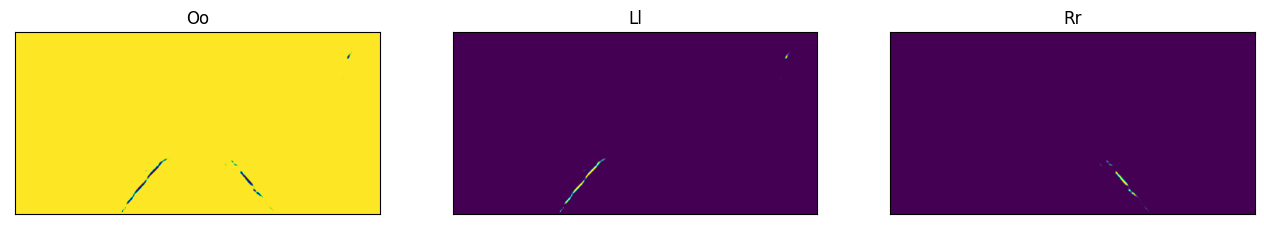

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 512, 1024)


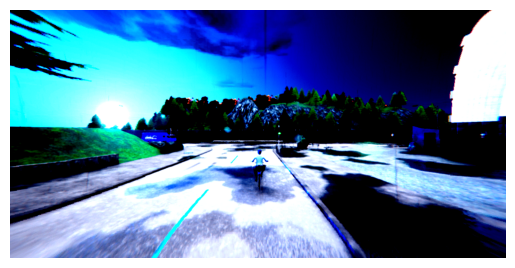

/home/ddmonster/MLMAS_Project/imgdata/saved_image_rgb_front_20240701_065326.png
(512, 1024, 4)
torch.Size([1, 3, 512, 1024])


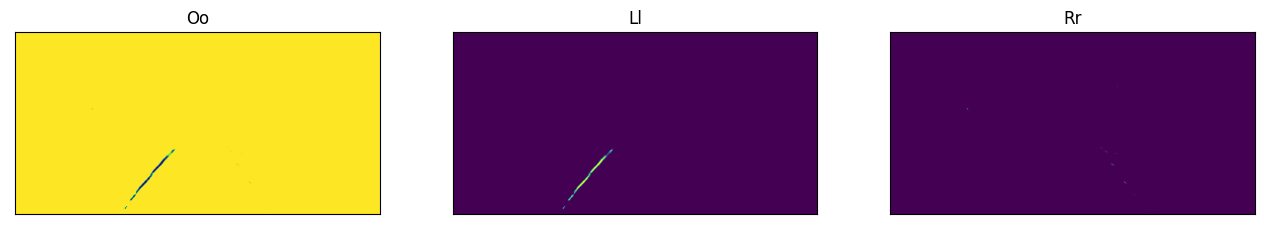

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 512, 1024)


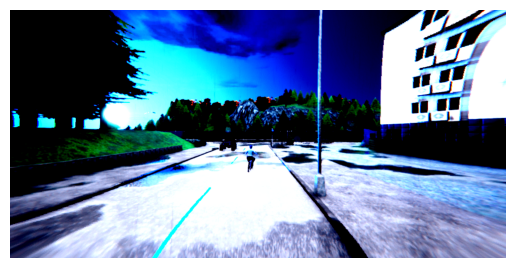

In [66]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import torch


ENCODER = 'efficientnet-b0'
ENCODER_WEIGHTS = 'imagenet'
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

def resize_width_crop_height(img, target_size):
    """
    Resize the image based on the width and crop the height to the target size.
    
    Parameters:
    - img: PIL Image object
    - target_size: tuple of (width, height)
    
    Returns:
    - img: PIL Image object of the target size
    """
    target_width, target_height = target_size
    
    # Calculate the new height maintaining the aspect ratio
    aspect_ratio = img.width / img.height
    new_height = int(target_width / aspect_ratio)
    
    # Resize the image based on the width
    img = img.resize((target_width, new_height), Image.ANTIALIAS)
    
    # If the new height is greater than the target height, crop the image from the center
    if new_height > target_height:
        top = (new_height - target_height) / 2
        bottom = (new_height + target_height) / 2
        img = img.crop((0, top, target_width, bottom))
    
    return img
from pathlib import Path

p = Path("/home/ddmonster/MLMAS_Project/imgdata")
ps = list(p.glob("*.png"))
for i in ps[3:10]:
    print(i)
    # Open the image file
    img = Image.open(i)

    target_size = (1024, 512)

    # Resize based on width and crop the height to the target size
    img_resized = resize_width_crop_height(img, target_size)
    print(np.shape(img_resized))
    # Convert RGBA to RGB if necessary
    if img_resized.mode == 'RGBA':
        img_resized = img_resized.convert('RGB')
    img_array = np.array(img_resized)

    img_array =  preprocessing_fn(img_array)
    # Convert the image to a NumPy array
    best_model = torch.load('./best_model_multi_dice_loss.pth')

    img_array = img_array.transpose(2,0,1).astype('float32')
    x_tensor = torch.from_numpy(img_array).to(DEVICE).unsqueeze(0)
    rs = best_model.predict(x_tensor)
    o = rs[0,0,:,:] 
    left = rs[0,1,:,:] 
    right = rs[0,2,:,:] 
    print(np.shape(rs))
    visualize(oo=o.cpu().numpy(),ll=left.cpu().numpy(),rr=right.cpu().numpy())
    print(np.shape(img_array))
    # Display the image using matplotlib
    plt.imshow(img_array.transpose(1,2,0))
    plt.axis('off')  # Hide axes ticks
    plt.show()
